In [63]:
import numpy
import matplotlib
from matplotlib import pylab, mlab, pyplot
np = numpy
plt = pyplot
from matplotlib.pyplot import *
import os
import glob
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs

from pylab import *
from numpy import *

import pandas as pd

from ipywidgets.widgets import interact, interactive, fixed
from ipywidgets import widgets
from scipy import fftpack
from IPython.display import display
from PIL import Image
import pims
import scipy.optimize as optimization
import pandas as pd
import pytube

# Example Particle tracking on video from youtube gridfs

The database is initally empty so we upload 

In [69]:
from pytube import YouTube

In [74]:
yt_video=YouTube('https://www.youtube.com/watch?v=AkRXCm2eZSA&feature=youtu.be')

In [75]:
yt_video.title

'microrheology_water_25C'

In [76]:
yt_video.description

'{  "muperpix": 0.1,  "filename": "400nm 100dil water 01umpix 100fps short.cin",  "fps":100,  "radius_tracer_nm":200 ,  "Fluorescence":false,  "temperature_C":25,  "shape_x":512,  "shape_y":512}'

In [77]:
import json
info=json.loads(yt_video.description)
info

{'muperpix': 0.1,
 'filename': '400nm 100dil water 01umpix 100fps short.cin',
 'fps': 100,
 'radius_tracer_nm': 200,
 'Fluorescence': False,
 'temperature_C': 25,
 'shape_x': 512,
 'shape_y': 512}

In [78]:
yt_video.streams.all()

[<Stream: itag="43" mime_type="video/webm" res="360p" fps="30fps" vcodec="vp8.0" acodec="vorbis">,
 <Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2">,
 <Stream: itag="36" mime_type="video/3gpp" res="240p" fps="30fps" vcodec="mp4v.20.3" acodec="mp4a.40.2">,
 <Stream: itag="17" mime_type="video/3gpp" res="144p" fps="30fps" vcodec="mp4v.20.3" acodec="mp4a.40.2">,
 <Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d401e">,
 <Stream: itag="134" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.4d4015">,
 <Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400c">,
 <Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400b">,
 <Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2">]

In [79]:
yt_video.streams.filter(adaptive=True).first().download('./')

'./microrheology_water_25C.mp4'

In [80]:
pims_video=pims.Video('microrheology_water_25C.mp4')

In [81]:
pims_video

<Frames>
Length: 300 frames
Frame Shape: 480 x 480
Pixel Datatype: uint8

In [82]:
from pims import pipeline

@pipeline
def as_grey(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

#pims_video=as_grey(pims.Video('microrhology_water_25C.mp4'))
pims_video=as_grey(pims.Video('microrheology_water_25C.mp4'))

In [83]:
pims_video.info=info
info

{'muperpix': 0.1,
 'filename': '400nm 100dil water 01umpix 100fps short.cin',
 'fps': 100,
 'radius_tracer_nm': 200,
 'Fluorescence': False,
 'temperature_C': 25,
 'shape_x': 512,
 'shape_y': 512}

In [84]:
shape(pims_video[0])

(480, 480)

Frame([[129., 126., 122., ..., 124., 124., 124.],
       [118., 117., 114., ..., 117., 117., 117.],
       [118., 118., 118., ..., 121., 121., 121.],
       ...,
       [125., 125., 125., ..., 124., 124., 124.],
       [124., 124., 124., ..., 123., 123., 123.],
       [117., 117., 117., ..., 117., 117., 117.]])
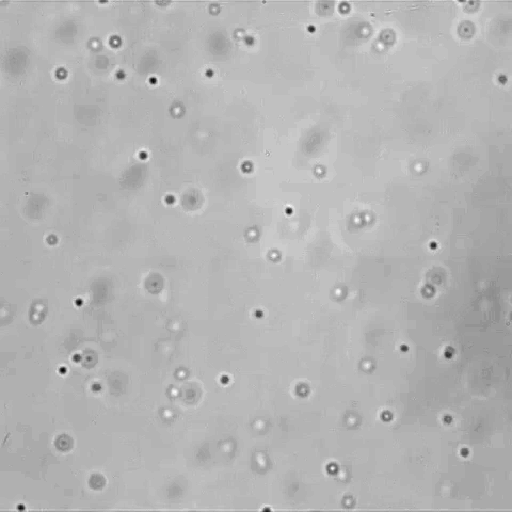

In [85]:
pims_video[0]

In [86]:
#Define simple video browser with ipywidgets

def browse_images_ptm(video):
    frames=len(video)
    interval=1/video.info['fps']
    muperpix=video.info['muperpix']
    filename=video.info['filename']
    pixpermu=1/muperpix
    
    def view_image(framenum):
        pyplot.figure(figsize=(6,6))
        toplot=video[framenum]
        pyplot.title(str(' time: ' + str(framenum*interval) + ' s'))
        pyplot.imshow(toplot)
        pyplot.set_cmap('gray')
        pyplot.axis('off')
        
    w=widgets.interactive(view_image, framenum=(0,frames-21))
    return w


In [87]:
browse_images_ptm(pims_video)

interactive(children=(IntSlider(value=139, description='framenum', max=279), Output()), _dom_classes=('widget-…

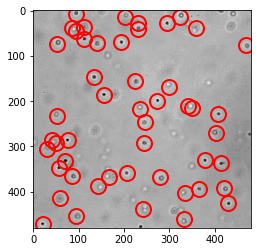

In [88]:
import trackpy as tp
fnum=10
fsingle = tp.locate(pims_video[fnum], 9, invert=True, minmass=100)
tp.annotate(fsingle, pims_video[fnum])

In [89]:
f = tp.batch(pims_video, 9, minmass=100, invert=True)
pims_video.result_PT=f

Frame 299: 35 features


In [92]:
def browse_images_tracked(video):
    frames=len(video)
    f=video.result_PT
    interval=1/video.info['fps']
    muperpix=video.info['muperpix']
    filename=video.info['filename']
    pixpermu=1/muperpix
    
    def view_image(framenum):
        pyplot.figure(figsize=(8,8))
        toplot=video[framenum]
        pyplot.title(str(' time: ' + str(framenum*interval) + ' s'))
        pyplot.imshow(toplot)
        pyplot.plot(f.x[f.frame==framenum],f.y[f.frame==framenum],'o')
        pyplot.set_cmap('gray')
        pyplot.axis('off')
        
    w=widgets.interactive(view_image, framenum=(0,frames-21))
    return w

In [93]:
browse_images_tracked(pims_video)

interactive(children=(IntSlider(value=139, description='framenum', max=279), Output()), _dom_classes=('widget-…

In [94]:
t = tp.link_df(f, 5, memory=3)

Frame 299: 35 trajectories present.


In [95]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,9.599045,320.210024,206.422424,2.310090,0.325376,11.823719,-5652.0,0.095111,0,0
24,275.940206,322.167010,119.468825,2.462921,0.275222,4.433895,-5760.0,0.139455,0,1
25,282.966370,73.645462,607.936208,2.122466,0.050934,31.037262,-4525.0,0.022026,0,2
26,291.886513,29.860197,149.767105,2.386227,0.256244,6.404514,-5557.0,0.074322,0,3
27,293.965361,242.244179,433.782683,2.241901,0.103874,18.967216,-4927.0,0.030342,0,4


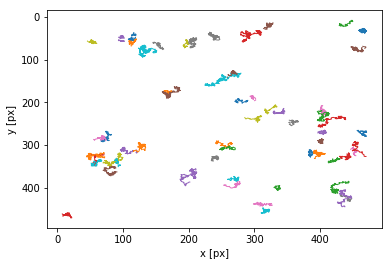

In [97]:
t1 = tp.filter_stubs(t, 50)
tp.plot_traj(t1)

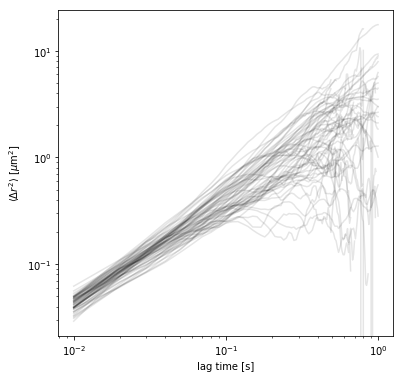

In [101]:
im = tp.imsd(t1, pims_video.info['muperpix']*info['shape_x']/480, pims_video.info['fps'])
im.plot(loglog=True, style='k-', alpha=0.1, legend=False, figsize=(6,6))
pyplot.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]');

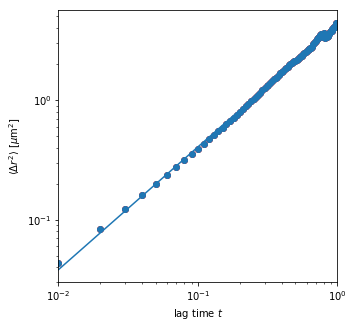

,n,A
msd,1.025472,4.310813


In [105]:
em = tp.emsd(t, pims_video.info['muperpix']*info['shape_x']/480, pims_video.info['fps'],max_lagtime=100)
em.plot(loglog=True, style='ro', figsize=(5,5))
pyplot.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
pyplot.xlabel('lag time $t$')

result=tp.utils.fit_powerlaw(em)
result

For Newtonian liquids:
* $n=1$
* $A=4D$, where $D$ is the particles’ diffusivity.

$D$ is related to viscosity $\eta$, particle radius $a$, and temperature $T$ as:
$$D=\frac{kT}{6 \pi \eta a}$$

In [109]:
kb=1.380E-23
tempK=273+pims_video.info['temperature_C']

float(kb*tempK*4/(6*3.14*result.A*1e-12*pims_video.info['radius_tracer_nm']*1e-9))

0.0010127104600918498